In [6]:
import pandas as pd
import os
from typing import List
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, hamming_loss, make_scorer, f1_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.decomposition import PCA
import numpy as np
from matplotlib.colors import ListedColormap
from imblearn.over_sampling import SMOTE
import seaborn as sns
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier



In [7]:
go_file = "/Users/kajolpatel/Desktop/Individual_Project/poc/go-basic.obo"

In [8]:
def parse_obo_file(file_path):
    
    data = []
    current_term = {}
    in_term_block = False
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == '[Term]':  #starting a new term block
                if current_term:
                    data.append(current_term)
                current_term = {}
                in_term_block = True
            elif line == '':
                in_term_block = False  #end of a term block
            elif in_term_block:
                if ': ' in line:
                    key, value = line.split(': ', 1)
                    if key in current_term:  #handling multiple lines of the same key
                        if isinstance(current_term[key], list):
                            current_term[key].append(value)
                        else:
                            current_term[key] = [current_term[key], value]
                    else:
                        current_term[key] = value

    
    if current_term: #add the last term if file does not end with a newline
        data.append(current_term)

    return pd.DataFrame(data)

df = parse_obo_file(go_file)


In [9]:
df = df.rename(columns={'def': 'definition'}) 

In [10]:
df.shape

(47856, 14)

In [11]:
df.head(3)

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
0,GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","""mitochondrial inheritance"" EXACT []","[GO:0048308 ! organelle inheritance, GO:004831...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,GO:0007005 ! mitochondrion organization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GO:0000003,obsolete reproduction,biological_process,"""OBSOLETE. The production of new individuals t...","""reproductive physiological process"" EXACT []",NaN,"[GO:0019952, GO:0050876]",The reason for obsoletion is that this term is...,true,GO:0022414,NaN,NaN,NaN,NaN


In [12]:
df.iloc[0]['is_a']

['GO:0048308 ! organelle inheritance',
 'GO:0048311 ! mitochondrion distribution']

In [13]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


In [14]:
print(df[df['is_a'].isna() == False].shape)
print(df[df['is_a'].isna() == True].shape)

(42200, 14)
(5656, 14)


Total records = 47856

42200 records have is_a relationship present

5656 records do not have is_a relationship present

### Data Preprocessing

#### 1. Excluding the records which do not have is_a

In [15]:
df = df[df['is_a'].notna()]

In [16]:
df[df.is_obsolete.isna() == True]

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
0,GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","""mitochondrial inheritance"" EXACT []","[GO:0048308 ! organelle inheritance, GO:004831...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,GO:0007005 ! mitochondrion organization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,"""Enables the transfer of zinc ions (Zn2+) from...","[""high affinity zinc uptake transmembrane tran...",GO:0005385 ! zinc ion transmembrane transporte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,"""Enables the transfer of a solute or solutes f...",NaN,GO:0005385 ! zinc ion transmembrane transporte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GO:0000009,"alpha-1,6-mannosyltransferase activity",molecular_function,"""Catalysis of the transfer of a mannose residu...","""1,6-alpha-mannosyltransferase activity"" EXACT []",GO:0000030 ! mannosyltransferase activity,NaN,NaN,NaN,NaN,NaN,"Reactome:R-HSA-449718 ""Addition of a third man...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47851,GO:2001313,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways involving...","""UDP-4-deoxy-4-formamido-beta-L-arabinopyranos...","[GO:0006040 ! amino sugar metabolic process, G...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47852,GO:2001314,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways resulting...","[""UDP-4-deoxy-4-formamido-beta-L-arabinopyrano...",[GO:0009227 ! nucleotide-sugar catabolic proce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47853,GO:2001315,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways resulting...","[""UDP-4-deoxy-4-formamido-beta-L-arabinopyrano...",[GO:0009226 ! nucleotide-sugar biosynthetic pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47854,GO:2001316,kojic acid metabolic process,biological_process,"""The chemical reactions and pathways involving...","[""5-hydroxy-2-(hydroxymethyl)-4H-pyran-4-one m...",[GO:0034308 ! primary alcohol metabolic proces...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Checking how many unique values is_a has

In [17]:
exploded_df = df.explode('is_a')

In [18]:
exploded_df['is_a'].value_counts().head(10)

is_a
GO:0110165 ! cellular anatomical entity                                                                                                                                              431
GO:0016616 ! oxidoreductase activity, acting on the CH-OH group of donors, NAD or NADP as acceptor                                                                                   310
GO:0032991 ! protein-containing complex                                                                                                                                              277
GO:0016709 ! oxidoreductase activity, acting on paired donors, with incorporation or reduction of molecular oxygen, NAD(P)H as one donor, and incorporation of one atom of oxygen    261
GO:0016758 ! hexosyltransferase activity                                                                                                                                             208
GO:0048856 ! anatomical structure development                         

#### 15547 unique is_a values

Checking if a GO term can have more than 9 is_a values

In [19]:
df[df['is_a'].apply(lambda x: len(x) > 9 if isinstance(x, list) else False)]

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
39234,GO:0140872,viridicatumtoxin biosynthetic process,biological_process,"""The chemical reactions and pathways resulting...","[""viridicatumtoxin anabolism"" EXACT [], ""virid...","[GO:0030639 ! polyketide biosynthetic process,...",NaN,NaN,NaN,NaN,NaN,MetaCyc:PWY-7659,NaN,NaN


#### 2. Converting the is_a values to only have GO term ids instead of names too :)

In [20]:
def extract_go_terms(s):
    go_terms = []

    if isinstance(s, list):
        for item in s:
            go_terms.extend(re.findall(r'GO:\d{7}', item))
    else:
        go_terms = re.findall(r'GO:\d{7}', s)
    return go_terms if len(go_terms) > 1 else (go_terms[0] if go_terms else None)

In [21]:
df.head(2)

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
0,GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","""mitochondrial inheritance"" EXACT []","[GO:0048308 ! organelle inheritance, GO:004831...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,GO:0007005 ! mitochondrion organization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df = df[['id','definition','is_a']]

In [23]:
df['is_a'] = df['is_a'].apply(extract_go_terms)

In [24]:
df

,id,definition,is_a
0,GO:0000001,"""The distribution of mitochondria, including t...","[GO:0048308, GO:0048311]"
1,GO:0000002,"""The maintenance of the structure and integrit...",GO:0007005
4,GO:0000006,"""Enables the transfer of zinc ions (Zn2+) from...",GO:0005385
5,GO:0000007,"""Enables the transfer of a solute or solutes f...",GO:0005385
7,GO:0000009,"""Catalysis of the transfer of a mannose residu...",GO:0000030
...,...,...,...
47851,GO:2001313,"""The chemical reactions and pathways involving...","[GO:0006040, GO:0006793, GO:0009225]"
47852,GO:2001314,"""The chemical reactions and pathways resulting...","[GO:0009227, GO:0046348, GO:2001313]"
47853,GO:2001315,"""The chemical reactions and pathways resulting...","[GO:0009226, GO:0046349, GO:2001313]"
47854,GO:2001316,"""The chemical reactions and pathways involving...","[GO:0034308, GO:0042180, GO:0120254]"


#### 3. Remove list from definitions

In [25]:
df['definition'] = df['definition'].str.replace(r' \[.*?\]$', '', regex=True)

In [26]:
df['definition'][0]

'"The distribution of mitochondria, including the mitochondrial genome, into daughter cells after mitosis or meiosis, mediated by interactions between mitochondria and the cytoskeleton."'

In [27]:
df

,id,definition,is_a
0,GO:0000001,"""The distribution of mitochondria, including t...","[GO:0048308, GO:0048311]"
1,GO:0000002,"""The maintenance of the structure and integrit...",GO:0007005
4,GO:0000006,"""Enables the transfer of zinc ions (Zn2+) from...",GO:0005385
5,GO:0000007,"""Enables the transfer of a solute or solutes f...",GO:0005385
7,GO:0000009,"""Catalysis of the transfer of a mannose residu...",GO:0000030
...,...,...,...
47851,GO:2001313,"""The chemical reactions and pathways involving...","[GO:0006040, GO:0006793, GO:0009225]"
47852,GO:2001314,"""The chemical reactions and pathways resulting...","[GO:0009227, GO:0046348, GO:2001313]"
47853,GO:2001315,"""The chemical reactions and pathways resulting...","[GO:0009226, GO:0046349, GO:2001313]"
47854,GO:2001316,"""The chemical reactions and pathways involving...","[GO:0034308, GO:0042180, GO:0120254]"


In [28]:
df['is_a'] = df['is_a'].apply(lambda x: x if isinstance(x, list) else [x])


In [29]:
df

,id,definition,is_a
0,GO:0000001,"""The distribution of mitochondria, including t...","[GO:0048308, GO:0048311]"
1,GO:0000002,"""The maintenance of the structure and integrit...",[GO:0007005]
4,GO:0000006,"""Enables the transfer of zinc ions (Zn2+) from...",[GO:0005385]
5,GO:0000007,"""Enables the transfer of a solute or solutes f...",[GO:0005385]
7,GO:0000009,"""Catalysis of the transfer of a mannose residu...",[GO:0000030]
...,...,...,...
47851,GO:2001313,"""The chemical reactions and pathways involving...","[GO:0006040, GO:0006793, GO:0009225]"
47852,GO:2001314,"""The chemical reactions and pathways resulting...","[GO:0009227, GO:0046348, GO:2001313]"
47853,GO:2001315,"""The chemical reactions and pathways resulting...","[GO:0009226, GO:0046349, GO:2001313]"
47854,GO:2001316,"""The chemical reactions and pathways involving...","[GO:0034308, GO:0042180, GO:0120254]"


### Selecting only the records which have is_a as the 10 most frequent values

In [30]:
exploded_df = df.explode('is_a')

In [33]:
exploded_df['is_a'].value_counts().head(20)

is_a
GO:0110165    431
GO:0016616    310
GO:0032991    277
GO:0016709    261
GO:0016758    208
GO:0048856    202
GO:0098797    180
GO:0140513    172
GO:0016747    153
GO:0003006    151
GO:1901700    142
GO:0016836    140
GO:0008757    135
GO:0016811    130
GO:0051241    130
GO:0016773    124
GO:0051240    124
GO:0008168    123
GO:0014070    123
GO:1901701    123
Name: count, dtype: int64

In [34]:
top_values_list = exploded_df['is_a'].value_counts().head(20).index.tolist()

In [35]:
top_values_list

['GO:0110165',
 'GO:0016616',
 'GO:0032991',
 'GO:0016709',
 'GO:0016758',
 'GO:0048856',
 'GO:0098797',
 'GO:0140513',
 'GO:0016747',
 'GO:0003006',
 'GO:1901700',
 'GO:0016836',
 'GO:0008757',
 'GO:0016811',
 'GO:0051241',
 'GO:0016773',
 'GO:0051240',
 'GO:0008168',
 'GO:0014070',
 'GO:1901701']

In [36]:
is_a_of_interest = ['GO:0110165', 'GO:0016616', 'GO:0032991', 'GO:0016709', 'GO:0016758', 'GO:0048856', 'GO:0098797', 'GO:0140513', 'GO:0016747', 'GO:0003006', 'GO:1901700', 'GO:0016836', 'GO:0008757',
 'GO:0016811', 'GO:0051241', 'GO:0016773', 'GO:0051240', 'GO:0008168', 'GO:0014070', 'GO:1901701']
filtered_df = df[df['is_a'].apply(lambda x: any(item in is_a_of_interest for item in (x if isinstance(x, list) else [x])))]

In [37]:
filtered_df

,id,definition,is_a
25,GO:0000030,"""Catalysis of the transfer of a mannosyl group...",[GO:0016758]
26,GO:0000031,"""Catalysis of the transfer of a mannosylphosph...",[GO:0016758]
88,GO:0000109,"""Any complex formed of proteins that act in nu...",[GO:0140513]
97,GO:0000118,"""A protein complex that possesses histone deac...","[GO:0140513, GO:1902494]"
98,GO:0000120,"""A transcription factor complex that acts at a...","[GO:0005667, GO:0140513]"
...,...,...,...
47383,GO:2000832,"""Any process that stops, prevents or reduces t...","[GO:0032369, GO:0046888, GO:0051241, GO:2000831]"
47384,GO:2000833,"""Any process that activates or increases the f...","[GO:0032370, GO:0046887, GO:0051240, GO:2000831]"
47657,GO:2001110,"""Any process that stops, prevents or reduces t...","[GO:0050680, GO:0051241, GO:2001109]"
47699,GO:2001152,"""Any process that stops, prevents or reduces t...","[GO:0051051, GO:0051241, GO:2001151]"


#### Converting the labels to vectors for 20 labels

In [38]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(filtered_df['is_a'])
y_df = pd.DataFrame(y, columns=mlb.classes_)

In [39]:
y_df = y_df[is_a_of_interest]

In [40]:
y_df

,GO:0110165,GO:0016616,GO:0032991,GO:0016709,GO:0016758,GO:0048856,GO:0098797,GO:0140513,GO:0016747,GO:0003006,GO:1901700,GO:0016836,GO:0008757,GO:0016811,GO:0051241,GO:0016773,GO:0051240,GO:0008168,GO:0014070,GO:1901701
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3563,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3564,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3565,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3566,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [41]:
y_df.columns

Index(['GO:0110165', 'GO:0016616', 'GO:0032991', 'GO:0016709', 'GO:0016758',
       'GO:0048856', 'GO:0098797', 'GO:0140513', 'GO:0016747', 'GO:0003006',
       'GO:1901700', 'GO:0016836', 'GO:0008757', 'GO:0016811', 'GO:0051241',
       'GO:0016773', 'GO:0051240', 'GO:0008168', 'GO:0014070', 'GO:1901701'],
      dtype='object')

#### Converting definition attribute to feature vectors for 20 labels

Excluding the words which appear in less than 1% of definitions

In [42]:
vectorizer = CountVectorizer(stop_words='english', min_df = 0.01)
X_tfidf = vectorizer.fit_transform(filtered_df['definition'])
X_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())


In [43]:
X_df

,acceptor,acetate,acetyl,acid,actin,activates,activity,acyl,adenosyl,adp,...,time,tissue,trans,transcription,transfer,transport,type,udp,wall,yeast
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3564,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#### 7. Normalised dataset

In [44]:
scaler = StandardScaler()

In [45]:
X_normalised_df = scaler.fit_transform(X_df)
X_normalised_df = pd.DataFrame(X_normalised_df, columns = X_df.columns)

In [46]:
X_normalised_df

,acceptor,acetate,acetyl,acid,actin,activates,activity,acyl,adenosyl,adp,...,time,tissue,trans,transcription,transfer,transport,type,udp,wall,yeast
0,8.389628,-0.10479,-0.119699,-0.153613,-0.09883,-0.180849,-0.346391,-0.100346,-0.258692,-0.173394,...,-0.246268,-0.103754,-0.091923,-0.097819,6.824519,-0.088518,-0.117267,-0.211492,-0.113283,-0.101637
1,-0.099933,-0.10479,-0.119699,-0.153613,-0.09883,-0.180849,-0.346391,-0.100346,-0.258692,-0.173394,...,-0.246268,-0.103754,-0.091923,-0.097819,6.824519,-0.088518,-0.117267,-0.211492,-0.113283,-0.101637
2,-0.099933,-0.10479,-0.119699,-0.153613,-0.09883,-0.180849,-0.346391,-0.100346,-0.258692,-0.173394,...,-0.246268,-0.103754,-0.091923,-0.097819,-0.142544,-0.088518,-0.117267,-0.211492,-0.113283,-0.101637
3,-0.099933,-0.10479,-0.119699,-0.153613,-0.09883,-0.180849,2.806477,-0.100346,-0.258692,-0.173394,...,-0.246268,-0.103754,-0.091923,-0.097819,-0.142544,-0.088518,-0.117267,-0.211492,-0.113283,-0.101637
4,-0.099933,-0.10479,-0.119699,-0.153613,-0.09883,-0.180849,-0.346391,-0.100346,-0.258692,-0.173394,...,-0.246268,-0.103754,-0.091923,7.024988,-0.142544,-0.088518,-0.117267,-0.211492,-0.113283,-0.101637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3563,-0.099933,-0.10479,-0.119699,-0.153613,-0.09883,-0.180849,-0.346391,-0.100346,-0.258692,-0.173394,...,-0.246268,-0.103754,-0.091923,-0.097819,-0.142544,-0.088518,-0.117267,-0.211492,-0.113283,-0.101637
3564,-0.099933,-0.10479,-0.119699,-0.153613,-0.09883,5.529487,-0.346391,-0.100346,-0.258692,-0.173394,...,-0.246268,-0.103754,-0.091923,-0.097819,-0.142544,-0.088518,-0.117267,-0.211492,-0.113283,-0.101637
3565,-0.099933,-0.10479,-0.119699,-0.153613,-0.09883,-0.180849,-0.346391,-0.100346,-0.258692,-0.173394,...,-0.246268,-0.103754,-0.091923,-0.097819,-0.142544,-0.088518,-0.117267,-0.211492,-0.113283,-0.101637
3566,-0.099933,-0.10479,-0.119699,-0.153613,-0.09883,-0.180849,-0.346391,-0.100346,-0.258692,-0.173394,...,-0.246268,-0.103754,-0.091923,-0.097819,-0.142544,6.930006,-0.117267,-0.211492,-0.113283,-0.101637


### Random Forests

##### 1. Non Normalised

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

In [48]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
#rf_model = OneVsRestClassifier(rf_model)  # Wrap with OneVsRestClassifier for multi-label classification
rf_model.fit(X_train, y_train)
# Predict on test data
y_pred_rf = rf_model.predict(X_test)

In [49]:
hamming_loss(y_test, y_pred_rf)

0.020868347338935573

In [50]:
print(classification_report(y_test, y_pred_rf, zero_division=0))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84        81
           1       1.00      0.97      0.98        66
           2       0.70      0.52      0.60        61
           3       0.96      1.00      0.98        45
           4       0.95      0.84      0.89        49
           5       0.91      0.91      0.91        43
           6       0.88      0.54      0.67        26
           7       0.64      0.42      0.51        38
           8       0.97      0.89      0.93        36
           9       0.61      0.61      0.61        33
          10       0.66      0.93      0.77        27
          11       0.67      0.86      0.75        28
          12       0.75      0.20      0.32        30
          13       0.79      0.46      0.58        24
          14       1.00      0.92      0.96        25
          15       1.00      0.76      0.87        17
          16       0.90      1.00      0.95        27
          17       0.41    

In [51]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [10, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 100],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
}
scoring = {'Hamming Loss': make_scorer(hamming_loss, greater_is_better=False)}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring=scoring, refit='Hamming Loss')

# Perform the search
grid_search.fit(X_train, y_train)

# Best parameter set
print('Best parameters found: \n', grid_search.best_params_)


In [238]:
grid_search.best_estimator_

RandomForestClassifier(n_estimators=300, random_state=42)

In [53]:
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [54]:
hamming_loss(y_test, y_pred_rf)

0.024892703862660945

In [60]:
print(classification_report(y_test, y_pred_rf, zero_division=0))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87        98
           1       1.00      1.00      1.00        76
           2       0.77      0.72      0.74        46
           3       1.00      0.96      0.98        50
           4       0.97      0.91      0.94        35
           5       0.96      0.89      0.92        53
           6       1.00      0.47      0.64        32
           7       0.67      0.59      0.63        27
           8       1.00      0.94      0.97        16
           9       0.81      0.68      0.74        38

   micro avg       0.92      0.83      0.87       471
   macro avg       0.91      0.80      0.84       471
weighted avg       0.92      0.83      0.87       471
 samples avg       0.83      0.83      0.83       471



Using f1-score for scoring

In [100]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [10, 100, 200, 300, 400, 1000, 2000],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 100, 200, 300],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 20, 30],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 10]     # Minimum number of samples required to be at a leaf node
}
scoring = {'F1-Score': make_scorer(f1_score, average='micro', needs_proba=False)}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring=scoring, refit='F1-Score', n_jobs=-1)

# Perform the search
grid_search.fit(X_train, y_train)

# Best parameter set
print('Best parameters found: \n', grid_search.best_params_)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found: 
 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


In [88]:
grid_search.best_estimator_

RandomForestClassifier(n_estimators=400, random_state=42)

In [98]:
rf_model = RandomForestClassifier(n_estimators=2000, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [99]:
print(classification_report(y_test, y_pred_rf, zero_division=0))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89        98
           1       1.00      1.00      1.00        76
           2       0.77      0.72      0.74        46
           3       1.00      0.96      0.98        50
           4       0.97      0.91      0.94        35
           5       0.96      0.91      0.93        53
           6       1.00      0.47      0.64        32
           7       0.70      0.59      0.64        27
           8       1.00      0.94      0.97        16
           9       0.87      0.68      0.76        38

   micro avg       0.92      0.84      0.88       471
   macro avg       0.92      0.81      0.85       471
weighted avg       0.92      0.84      0.87       471
 samples avg       0.84      0.84      0.84       471



In [ ]:
report_data = classification_report(y_test, y_pred_rf, zero_division=0)

In [41]:
lines = report_data.strip().split("\n")[1:]

In [42]:
data = []
for line in lines:
    parts = line.split()
    # Ensure that we have enough parts to form a full row of data
    if len(parts) == 5:
        data.append({
            'Label': parts[0],
            'Precision': float(parts[1]),
            'Recall': float(parts[2]),
            'F1-Score': float(parts[3]),
            'Support': int(parts[4])
        })

# Convert the list of dictionaries to a DataFrame
class_df = pd.DataFrame(data)
class_df['Label'] = is_a_of_interest

print(class_df)

        Label  Precision  Recall  F1-Score  Support
0  GO:0110165       0.90    0.88      0.89       98
1  GO:0016616       1.00    1.00      1.00       76
2  GO:0032991       0.70    0.67      0.69       46
3  GO:0016709       1.00    0.96      0.98       50
4  GO:0016758       0.97    0.91      0.94       35
5  GO:0048856       0.96    0.92      0.94       53
6  GO:0098797       1.00    0.50      0.67       32
7  GO:0140513       0.71    0.63      0.67       27
8  GO:0016747       1.00    0.94      0.97       16
9  GO:0003006       0.70    0.68      0.69       38


In [46]:
class_df

,Label,Precision,Recall,F1-Score,Support
0,GO:0110165,0.90,0.88,0.89,98
1,GO:0016616,1.00,1.00,1.00,76
2,GO:0032991,0.70,0.67,0.69,46
3,GO:0016709,1.00,0.96,0.98,50
4,GO:0016758,0.97,0.91,0.94,35
5,GO:0048856,0.96,0.92,0.94,53
6,GO:0098797,1.00,0.50,0.67,32
7,GO:0140513,0.71,0.63,0.67,27
8,GO:0016747,1.00,0.94,0.97,16
9,GO:0003006,0.70,0.68,0.69,38


/var/folders/94/76mh2c695q3d9y8r3k0mx2hr0000gn/T/ipykernel_97430/2755443483.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')  # Clean and minimal background


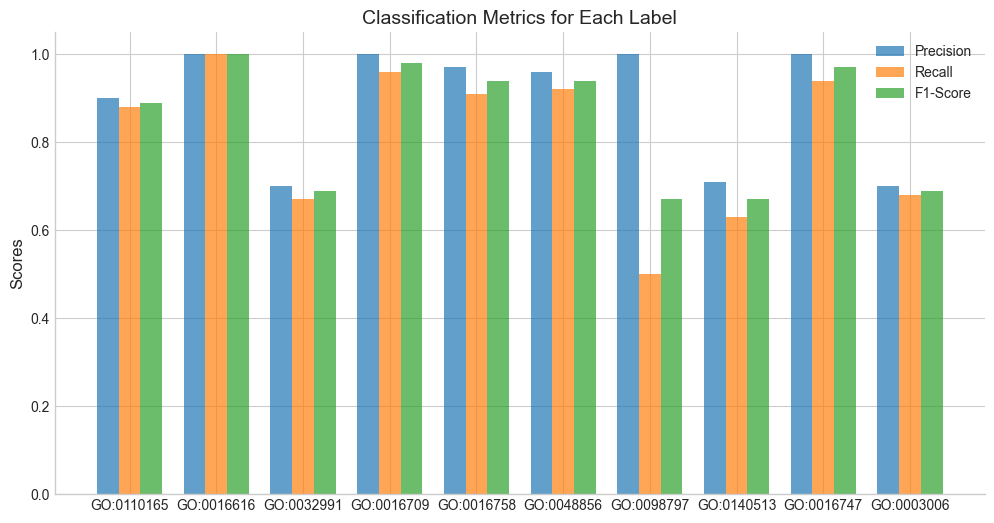

In [45]:
plt.style.use('seaborn-whitegrid')  # Clean and minimal background

# Setting the positions and width for the bars
pos = list(range(len(class_df['Precision'])))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for Precision, Recall, F1-Score
bar1 = plt.bar(pos, class_df['Precision'], width, alpha=0.7, color='#1f77b4', label='Precision')
bar2 = plt.bar([p + width for p in pos], class_df['Recall'], width, alpha=0.7, color='#ff7f0e', label='Recall')
bar3 = plt.bar([p + width*2 for p in pos], class_df['F1-Score'], width, alpha=0.7, color='#2ca02c', label='F1-Score')

# Adding and setting labels and title
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Classification Metrics for Each Label', fontsize=14)
ax.set_xticks([p + width for p in pos])
ax.set_xticklabels(class_df['Label'])

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adding the legend
plt.legend(frameon=False)

# Show the plot
plt.show()

#### Support Vector Machines

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

In [305]:
svm_model = OneVsRestClassifier(SVC(random_state=42))
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [306]:
hamming_loss(y_test, y_pred_svm)

0.02982832618025751

In [307]:
# Print classification report
print(classification_report(y_test, y_pred_svm, zero_division=0))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87        98
           1       1.00      0.97      0.99        76
           2       0.64      0.59      0.61        46
           3       1.00      0.92      0.96        50
           4       0.97      0.80      0.88        35
           5       0.96      0.91      0.93        53
           6       1.00      0.44      0.61        32
           7       0.81      0.48      0.60        27
           8       0.78      0.88      0.82        16
           9       0.92      0.58      0.71        38

   micro avg       0.90      0.79      0.84       471
   macro avg       0.89      0.74      0.80       471
weighted avg       0.90      0.79      0.83       471
 samples avg       0.80      0.79      0.79       471



In [298]:
# Define the SVM model wrapped in OneVsRestClassifier
svm_model = OneVsRestClassifier(SVC(random_state=42))

# Define the parameter grid for GridSearchCV
param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__gamma': ['scale', 'auto',0.001, 0.01, 0.1, 1, 10]
}

# Create a scorer dictionary to include Hamming Loss
scoring = {'Hamming Loss': make_scorer(hamming_loss, greater_is_better=False)}

# Set up GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, scoring=scoring, refit='Hamming Loss', cv=3, n_jobs=-1)
# Perform the search
grid_search.fit(X_train, y_train)

# Best parameter set
print('Best parameters found: \n', grid_search.best_params_)


Best parameters found: 
 {'estimator__C': 10, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf'}


In [65]:
svm_model = OneVsRestClassifier(SVC(C= 10, gamma = 0.1, random_state=42))
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)


In [66]:
hamming_loss(y_test, y_pred_svm)

0.02832618025751073

In [67]:
print(classification_report(y_test, y_pred_svm, zero_division=0))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        98
           1       1.00      0.97      0.99        76
           2       0.70      0.61      0.65        46
           3       1.00      0.94      0.97        50
           4       0.92      0.97      0.94        35
           5       0.92      0.87      0.89        53
           6       1.00      0.59      0.75        32
           7       0.60      0.67      0.63        27
           8       0.93      0.88      0.90        16
           9       0.82      0.61      0.70        38

   micro avg       0.89      0.82      0.85       471
   macro avg       0.88      0.80      0.83       471
weighted avg       0.89      0.82      0.85       471
 samples avg       0.82      0.83      0.82       471



In [312]:
y_pred_svm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [ ]:
exploded_df = df.explode('is_a')

In [ ]:
exploded_df['is_a'].value_counts().head(10)

is_a
GO:0110165    431
GO:0016616    310
GO:0032991    277
GO:0016709    261
GO:0016758    208
GO:0048856    202
GO:0098797    180
GO:0140513    172
GO:0016747    153
GO:0003006    151
Name: count, dtype: int64

In [ ]:
is_a_of_interest = ["GO:0110165","GO:0016616", "GO:0032991", "GO:0016709", "GO:0016758", "GO:0048856", "GO:0098797", "GO:0140513", "GO:0016747", "GO:0003006"]
filtered_df = df[df['is_a'].apply(lambda x: any(item in is_a_of_interest for item in (x if isinstance(x, list) else [x])))]

#### Converting the labels to vectors for 10 labels

In [ ]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(filtered_df['is_a'])
y_df = pd.DataFrame(y, columns=mlb.classes_)

In [ ]:
y_df = y_df[is_a_of_interest]

In [ ]:
y_df

,GO:0110165,GO:0016616,GO:0032991,GO:0016709,GO:0016758,GO:0048856,GO:0098797,GO:0140513,GO:0016747,GO:0003006
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2325,0,0,1,0,0,0,0,0,0,0
2326,1,0,0,0,0,0,0,0,0,0
2327,0,0,1,0,0,0,0,0,0,0
2328,0,0,1,0,0,0,0,0,0,0


In [ ]:
y_df.columns

Index(['GO:0110165', 'GO:0016616', 'GO:0032991', 'GO:0016709', 'GO:0016758',
       'GO:0048856', 'GO:0098797', 'GO:0140513', 'GO:0016747', 'GO:0003006'],
      dtype='object')